In [1]:
import tensorflow as tf

# TensorFlow 버전 확인
print("TensorFlow version:", tf.__version__)

# GPU 사용 가능 여부 확인
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version: 2.10.0
Num GPUs Available:  1


In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import os
import sys

BASE_DIR = os.path.dirname(os.path.abspath(os.path.abspath('')))
WORK_DIR = os.path.join(BASE_DIR, 'code')
sys.path.append(WORK_DIR)
print('base dir: ', BASE_DIR)

base dir:  c:\Users\user1\Desktop\BONBID Project


In [4]:
import numpy as np
import random

# 난수 시드 설정
seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 첫 번째 GPU 사용 ("0", "1" 등으로 설정 가능)

In [5]:
# 데이터 경로 설정
TRAIN_ADC_CONVERTED_PATH = os.path.join(BASE_DIR, 'data/train/converted/1ADC_ss')
TRAIN_Z_ADC_CONVERTED_PATH = os.path.join(BASE_DIR, 'data/train/converted/2Z_ADC')
TRAIN_LABEL_CONVERTED_PATH = os.path.join(BASE_DIR, 'data/train/converted/3LABEL')

VAL_ADC_CONVERTED_PATH = os.path.join(BASE_DIR, 'data/val/converted/1ADC_ss')
VAL_Z_ADC_CONVERTED_PATH = os.path.join(BASE_DIR, 'data/val/converted/2Z_ADC')
VAL_LABEL_CONVERTED_PATH = os.path.join(BASE_DIR, 'data/val/converted/3LABEL')

TEST_ADC_CONVERTED_PATH = os.path.join(BASE_DIR, 'data/test/converted/1ADC_ss')
TEST_Z_ADC_CONVERTED_PATH = os.path.join(BASE_DIR, 'data/test/converted/2Z_ADC')
TEST_LABEL_CONVERTED_PATH = os.path.join(BASE_DIR, 'data/test/converted/3LABEL')

# output_dir = os.path.join(BASE_DIR, 'data/train/processed')
# model_save_dir = os.path.join(project_base_dir, 'small_data/models')

# 모델 저장 디렉토리가 존재하지 않으면 생성
# if not os.path.exists(model_save_dir):
#     os.makedirs(model_save_dir)

In [6]:
# 데이터셋 로드
import sys
from preprocessing import create_and_preprocess_dataset
from monai.data import DataLoader
import tensorflow as tf
from preprocessing import convert_monai_to_tf_dataset

train_monai_dataset = create_and_preprocess_dataset(
    TRAIN_ADC_CONVERTED_PATH,
    TRAIN_Z_ADC_CONVERTED_PATH,
    TRAIN_LABEL_CONVERTED_PATH,
    is_train=True,
    is_aug=False
)

val_monai_dataset = create_and_preprocess_dataset(
    VAL_ADC_CONVERTED_PATH,
    VAL_Z_ADC_CONVERTED_PATH,
    VAL_LABEL_CONVERTED_PATH,
    is_train=False,
    is_aug=False
)

test_monai_dataset = create_and_preprocess_dataset(
    TEST_ADC_CONVERTED_PATH,
    TEST_Z_ADC_CONVERTED_PATH,
    TEST_LABEL_CONVERTED_PATH,
    is_train=False,
    is_aug=False
)

# Convert MONAI datasets to TensorFlow datasets
train_tf_dataloader = convert_monai_to_tf_dataset(train_monai_dataset, batch_size=1)
val_tf_dataloader = convert_monai_to_tf_dataset(val_monai_dataset, batch_size=1)
test_tf_dataloader = convert_monai_to_tf_dataset(test_monai_dataset, batch_size=1)

In [7]:
# GPU 메모리 설정
def set_gpu_memory_growth():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f"Enabled memory growth for {len(gpus)} GPU(s)")
        except RuntimeError as e:
            print(e)

In [8]:
import matplotlib.pyplot as plt

# 결과 시각화 함수
def plot_history(history):
    epochs_range = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, history.history['loss'], 'ro-', label='Training Loss')
    plt.plot(epochs_range, history.history['val_loss'], 'bo-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, history.history['accuracy'], 'ro-', label='Training Accuracy')
    plt.plot(epochs_range, history.history['val_accuracy'], 'bo-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(epochs_range, history.history['mean_io_u'], 'ro-', label='Training Mean IoU')
    plt.plot(epochs_range, history.history['val_mean_io_u'], 'bo-', label='Validation Mean IoU')
    plt.title('Training and Validation Mean IoU')
    plt.xlabel('Epoch')
    plt.ylabel('Mean IoU')
    plt.legend()

    # dice_metric_and_loss로 변경
    plt.subplot(2, 2, 4)
    plt.plot(epochs_range, history.history['dice_metric_and_loss'], 'ro-', label='Training Dice Coefficient')
    plt.plot(epochs_range, history.history['val_dice_metric_and_loss'], 'bo-', label='Validation Dice Coefficient')
    plt.title('Training and Validation Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [9]:
from Model import Unet3DModel

# 모델 훈련 및 결과 시각화
def train_and_evaluate_model(train_tf_dataloader, val_tf_dataloader, img_height=256, img_width=256, img_depth=64, img_channels=2, batch_size=1, epochs=100):
    set_gpu_memory_growth()
    model = Unet3DModel(img_height=img_height, img_width=img_width, img_depth=img_depth, img_channels=img_channels)

    # 모델 훈련
    history = model.train(train_tf_dataloader, val_tf_dataloader, batch_size=batch_size, epochs=epochs)

    # 결과 시각화
    plot_history(history)

Physical devices cannot be modified after being initialized
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 256, 256, 6  0           []                               
                                4, 2)]                                                            
                                                                                                  
 conv3d (Conv3D)                (None, 256, 256, 64  880         ['image[0][0]']                  
                                , 16)                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  64         ['conv3d[0][0]']                 
 alization)                     , 

KeyError: 'dice_coefficient'

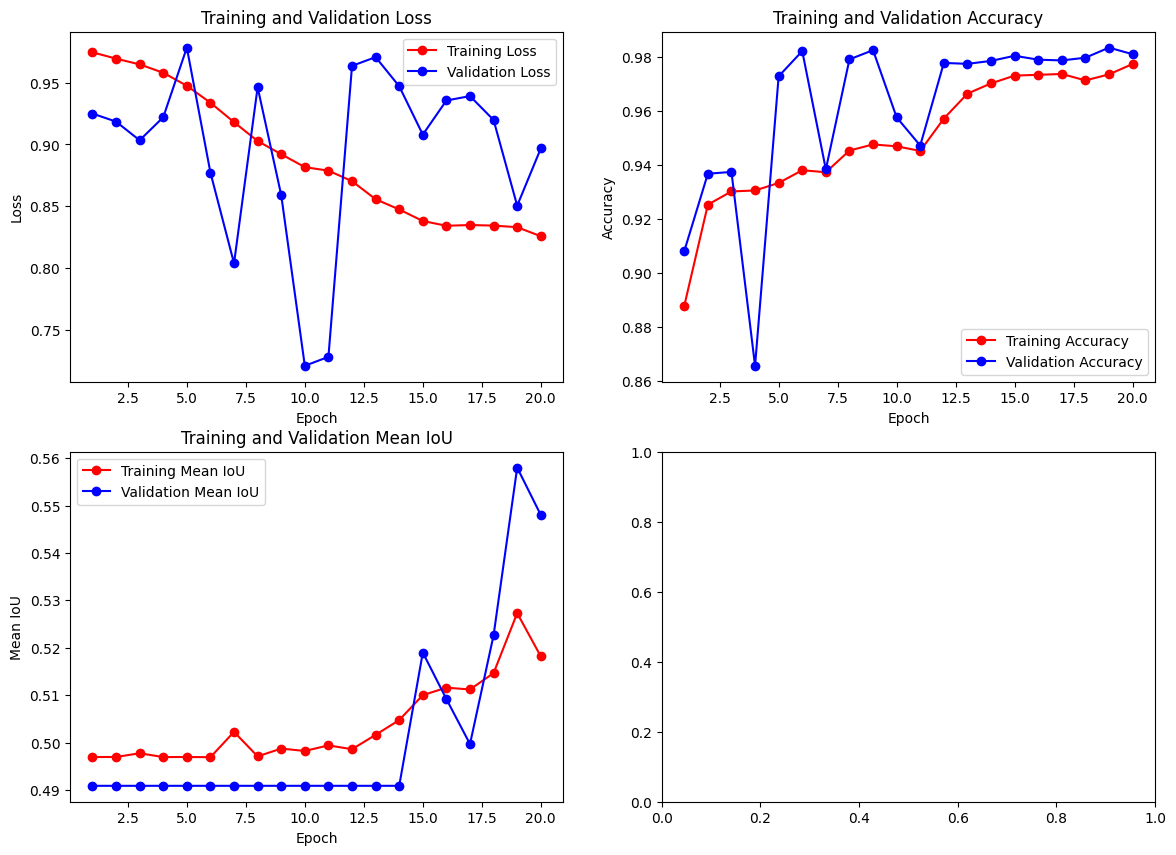

In [10]:
train_and_evaluate_model(train_tf_dataloader, val_tf_dataloader)

In [14]:
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import MeanIoU
import numpy as np
from tensorflow.keras.models import load_model
from DiceCoefficient import DiceMetricAndLoss

model = load_model(r"C:\Users\user1\Desktop\BONBID Project\models\No_Aug_Model.keras", 
                   custom_objects={'MeanIoU': MeanIoU, 'DiceMetricAndLoss': DiceMetricAndLoss, 'compute_loss': DiceMetricAndLoss().compute_loss})

def evaluate_model(model, test_tf_dataloader):
    results = model.evaluate(test_tf_dataloader)
    print(f"Validation Loss: {results[0]}")
    print(f"Validation Accuracy: {results[1]}")
    print(f"Mean IoU: {results[2]}")
    print(f"Dice Coefficient: {results[3]}")

evaluate_model(model, val_tf_dataloader)

ValueError: Unknown loss function: compute_loss. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, test_tf_dataloader, num_samples=4):
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5 * num_samples))

    for i, (data, label) in enumerate(val_tf_dataloader.take(num_samples)):
        prediction = model.predict(data)
        image = data.numpy().squeeze()
        label = label.numpy().squeeze()
        prediction = prediction.squeeze()

        # 이진화 과정 추가
        threshold = 0.5
        prediction_binary = (prediction >= threshold).astype(np.float32)

        slice_idx = image.shape[2] // 2  # 중앙 슬라이스 선택

        # 첫 번째 채널의 입력 이미지 시각화
        axes[i, 0].imshow(image[:, :, slice_idx, 0], cmap='gray')
        axes[i, 0].set_title('Input Image - Channel 1')
        axes[i, 0].axis('off')

        # 두 번째 채널의 입력 이미지 시각화
        axes[i, 1].imshow(image[:, :, slice_idx, 1], cmap='gray')
        axes[i, 1].set_title('Input Image - Channel 2')
        axes[i, 1].axis('off')

        # 실제 마스크 시각화
        axes[i, 2].imshow(label[:, :, slice_idx], cmap='gray')
        axes[i, 2].set_title('True Mask')
        axes[i, 2].axis('off')

        # 예측된 마스크 시각화
        axes[i, 3].imshow(prediction_binary[:, :, slice_idx], cmap='gray')
        axes[i, 3].set_title('Predicted Mask')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_tf_dataloader, num_samples=4)